# **<span style="color:red">Solutions 3</span>**

## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Winter 2025

#### Notation Commands

$$\newcommand{\cpn}{\text{c}}$$
$$\newcommand{\Tunder}{T_\text{bond}}$$
$$\newcommand{\accint}{\xi}$$
$$\newcommand{\convert}{\psi}$$
$$\newcommand{\ctd}{\text{ctd}}$$

$$\newcommand{\refrate}{r^{\text{ref}}}$$
$$\newcommand{\pfwd}{P_{\text{fwd}}}$$
$$\newcommand{\grossbasis}{B}$$
$$\newcommand{\netbasis}{\tilde{\grossbasis}}$$
$$\newcommand{\pnl}{\Pi}$$

$$\newcommand{\years}{\tau}$$
$$\newcommand{\yearsACT}{\years_{\text{act/360}}}$$

$$\newcommand{\fwdprice}{\mathcal{F}_{t\to T}}$$
$$\newcommand{\futprice}{F_{t\to T}}$$

$$\newcommand{\fwdpriceT}{\mathcal{F}_{T\to T}}$$
$$\newcommand{\futpriceT}{F_{T\to T}}$$

$$\newcommand{\fwdpriceDT}{\mathcal{F}_{t+h\to T}}$$
$$\newcommand{\futpriceDT}{F_{t+h\to T}}$$

$$\newcommand{\rrepo}{r^{\text{repo}}}$$
$$\newcommand{\carry}{\widetilde{\cpn}}$$

***

# 1. Trading Bonds

### Data

The file `data/fut_bond_data_TYZ4_2024-08-01.xlsx` has market data on the following:
* 10-year Treasury future, expiring December 2024
* The specifications of the deliverable treasury bonds

Suppose the present date is `2024-08-01`.

### 1.1
For each bond, calculate the 
* gross basis
* carry
* net basis 

Your calculations will be more accurate if you consider that it takes time for any trade to "settle". Assume it takes one day.

#### Tip: Calculate Gross Basis using Conversion Factor

$$\underbrace{\grossbasis_{t,t+\tau}^i}_{\text{gross basis}}=\;  P_t^i - \convert^i\futprice$$

where $\convert$ denotes the **conversion factor** which is defined for each bond. You can find the conversion factor in the `conversion` column of the `bonds` sheet of the data.

Why the use of a conversion factor?
* The deliverable bonds differ in maturity and coupon, and thus range in value.
* To account for this, CBOT uses a **conversion factor** such that the futures price at delivery for bond $i$ is
$$\futpriceT\convert^i$$


#### Tip: Calculate Net Basis as Gross Basis Minus Carry

$$\begin{align*}
\text{net basis} \equiv \netbasis^i_{t,T} =& \grossbasis^i_{t,T} - \left(\cpn N - \rrepo P_t^{i,\text{dirty}}\right)\yearsACT\\
=& \grossbasis^i_{t,T} - \left[\cpn N - \rrepo \left(P_t^{i} + \accint_t^i\right)\right]\yearsACT
\end{align*}$$

recalling that
* $N$ denotes the notional, (here face value of 100)
* $\accint$ denotes accrued interest
* $\rrepo$ denotes the repo rate
* $\yearsACT$ denotes the time interval quoted as ACT/360

### 1.2.
If you were required to put on a position today
* long one of the bonds
* short the future

which would you choose based on the data provided in the spreadsheet?

### 1.3.

Calculate the conversion factor for each bond. Report it to `6` decimal places.

Do they match the conversion factor provided by Bloomberg?


#### Tip: Calculating the Conversion Factor

CBOT calculates the conversion for any bond as the discounted cashflows of the bond, where every cashflow is discounted by 6\%.
* Yes, this conversion factor formula always uses 6\%, regardless of actual interest rates.

### 1.4 

Calculate the forward price of each bond.

Use the forward prices to do an alternate calculation of net basis, using the formula in the discussion notebook.

Does this calculation agree with the net basis calculation which used gross basis minus carry?


#### Calculate net basis using forward price 

Net basis is also calculated with the same formula as gross basis, but replacing the spot price with the forward price:

$$\text{net basis} \equiv \netbasis^i_{t,T} = \fwdprice^i - \futprice\convert^i$$

recalling that
* $\fwdprice$ denotes the forward price
* $\futprice$ denotes the futures price
* $\convert$ denotes the bond's conversion factor

As we saw in Week 2, no-arbitrage (and frictionless markets) would imply the forward price is exactly the spot price minus carry, in which case this definition would match.

### Forward Price

The forward price is given by the no-arbitrage relationship:

$$\begin{align*}
\text{dirty} \fwdprice =& (P_t^i + \accint_t^i)\left(1+\rrepo_t\, \yearsACT\right)\\
\fwdprice =& (P_t^i + \accint^i_t)\left(1+\rrepo_t\, \yearsACT\right) - \accint_T
\end{align*}$$


#### With interim coupons
If there are interim coupons, the no-arbitrage relationship still holds,
* buy the bond at the dirty price
* simultaneously repo it
* when the coupon pays, use it to reduce the repo balance
* finally, at the terminal date, close out the repo

$$\begin{align*}
\text{dirty} \fwdprice =& \left[(P_t^i + \accint_t)\left(1+\rrepo_t\, \tau_0\right)-100\frac{\cpn}{2}\right]\left(1+\rrepo_t\, \tau_1\right)\\
\fwdprice =& \left[(P^i_t + \accint^i_t)\left(1+\rrepo_t\, \tau_0\right)-100\frac{\cpn}{2}\right]\left(1+\rrepo_t\, \tau_1\right) - \accint^i_T
\end{align*}$$
where
* $\tau_0$ denotes the pre-coupon forward interval, $t_{\text{coupon}}-t$ denoted as ACT/360
* $\tau_1$ denotes the pre-coupon forward interval, $T-t_{\text{coupon}}$ denoted as ACT/360
* note that $\tau=\tau_0+\tau_1$, so the formula is simply splitting the forward interval into pre and post-coupon intervals.

***

# **<span style="color:red">Solution 1</span>**

In [1]:
import numpy as np
import pandas as pd

from datetime import date
from datetime import datetime

import sys
sys.path.insert(0, '../cmds')
from ficcvol import *
from binomial import *
from ratecurves import *

In [2]:
import datetime
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import matplotlib.ticker as mtick
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

## Parameters

In [3]:
DATE = '2024-08-01'
FREQ = 52
futtick = 'TYZ4'

FACE = 100

DAYS_YEAR = 365
DAYS_TBILL_DENOM = 360

## Load Market Data

In [4]:
futdata = pd.read_excel(f'../data/fut_bond_data_{futtick}_{DATE}.xlsx', sheet_name=f'future').set_index('field').iloc[:,0]
futdata

field
last_update_dt         2024-08-02 00:00:00
px_last                         114.234375
last_tradeable_dt      2024-12-19 00:00:00
fut_dlv_dt_last        2024-12-31 00:00:00
fut_days_expire                        139
fut_ctd                    T 4.25 06/30/31
fut_ctd_px                      103.296875
fut_ctd_gross_basis               -9.67291
fut_ctd_net_basis                 2.684063
Name: TYZ4 Comdty, dtype: object

In [5]:
bonddata = pd.read_excel(f'../data/fut_bond_data_{futtick}_{DATE}.xlsx', sheet_name=f'bonds').set_index('ticker')
bonddata

,last_update_dt,px_last,maturity,days_to_mty,dur_adj_mid,cpn,nxt_cpn_dt,days_to_next_coupon,int_acc,accrued_days_between_cpn_dates,days_acc,basis_mid,repo_implied_reporate,repo_reporate,conversion
ticker,,,,,,,,,,,,,,,
91282CCS Govt,2024-08-02,84.843750,2031-08-15,2566,6.550426,1.250,2024-08-15,10,0.590659,182,172,46.253746,3.646209,5.375,0.7474
91282CDJ Govt,2024-08-02,85.062500,2031-11-15,2658,6.763513,1.375,2024-11-15,102,0.306386,184,82,55.779000,3.623413,5.375,0.7463
91282CDY Govt,2024-08-02,87.796875,2032-02-15,2750,6.816994,1.875,2024-08-15,10,0.885989,182,172,65.717750,3.675354,5.375,0.7670
91282CEP Govt,2024-08-02,94.078125,2032-05-15,2840,6.820612,2.875,2024-11-15,102,0.640625,184,82,75.048750,3.644107,5.375,0.8184
91282CFF Govt,2024-08-02,93.000000,2032-08-15,2932,6.990905,2.750,2024-08-15,10,1.299451,182,172,86.003250,3.692673,5.375,0.8060
91282CFV Govt,2024-08-02,102.531250,2032-11-15,3024,6.921134,4.125,2024-11-15,102,0.919158,184,82,NaN,3.649617,5.375,0.8851
91282CKW Govt,2024-08-02,103.296875,2031-06-30,2520,5.937053,4.250,2024-12-31,148,0.415761,184,36,43.819996,3.590292,5.375,0.9069
91282CLD Govt,2024-08-02,102.546875,2031-07-31,2551,6.038217,4.125,2025-01-31,179,0.056046,184,5,44.961746,3.594133,5.375,0.9003


### Calculate Gross Basis

$$\text{gross basis} \equiv \grossbasis^i_{t,T} = P_t^i - \futprice\convert^i$$

In [6]:
px = bonddata['px_last']

gross_basis = (px - futdata.loc['px_last'] * bonddata['conversion']).to_frame().rename(columns={0:'dollars'})
gross_basis['32nds'] = gross_basis * 32
gross_basis.columns.name = 'gross basis'
gross_basis

gross basis,dollars,32nds
ticker,,
91282CCS Govt,-0.535022,-17.12070
91282CDJ Govt,-0.190614,-6.09965
91282CDY Govt,0.179109,5.73150
91282CEP Govt,0.588712,18.83880
91282CFF Govt,0.927094,29.66700
91282CFV Govt,1.422405,45.51695
91282CKW Govt,-0.302280,-9.67295
91282CLD Govt,-0.298333,-9.54665


#### Confirm Bloomberg

Note that the provided futures data gives Bloomberg's calculation of which bond is CTD and its associated gross basis.

Our calculation of gross basis matches (quoted in 32nds).

### Calculate Net Basis

In [7]:
days_settle = 1

In [8]:
cpn = bonddata['cpn']/100
repo = bonddata['repo_reporate']/100

days_fwd = futdata.loc['fut_days_expire'] - days_settle
days_cpn_period = bonddata['accrued_days_between_cpn_dates']
days_already_accrued = bonddata['days_acc'] + days_settle

int_already_acc = cpn*FACE/2 * (days_already_accrued / days_cpn_period)
pxdirty = px + int_already_acc

carry = ((FACE * cpn - repo * pxdirty) * days_fwd / DAYS_TBILL_DENOM).to_frame().rename(columns={0:'dollars'})
carry['32nds'] = carry * 32
net_basis = gross_basis - carry
net_basis.columns.name = 'net basis'
net_basis

net basis,dollars,32nds
ticker,,
91282CCS Govt,0.746187,23.877985
91282CDJ Govt,1.041334,33.322699
91282CDY Govt,1.287702,41.206465
91282CEP Govt,1.438391,46.028514
91282CFF Govt,1.816044,58.113419
91282CFV Govt,1.972895,63.132643
91282CKW Govt,0.205704,6.582529
91282CLD Govt,0.234696,7.510267


#### Confirm

CTD
* The bond with the smallest net basis is seen by the market as being most likely to be CTD.
* The corresponding bond indeed matches what Bloomberg's future data reported as the CTD bond.

Negative net basis?
* If the net basis is negative, which would suggest an arbitrage is possible.
* Due to market frictions, we shouldn't be surprised to see this slight negative value.
* Trading on it would require us to short the future and go long the bond. There will be some cost of capital in the position.

In [9]:
days_next_cpn_period = DAYS_YEAR-days_cpn_period
days_next_cpn = bonddata['days_to_next_coupon'] - days_settle
days_past_cpn = (days_fwd - days_next_cpn)
days_terminal_accrued = days_already_accrued + days_fwd

int_postcpn_acc = cpn*FACE/2 * (days_past_cpn / days_next_cpn_period)

fwd_prices = ((px + int_already_acc)  * (1+repo * days_next_cpn/DAYS_TBILL_DENOM) - FACE*cpn/2) * (1+repo * days_past_cpn/DAYS_TBILL_DENOM) - int_postcpn_acc
fwd_prices.to_frame().rename(columns={0:'forward price'}).style.format('{:.4f}')

,forward price
ticker,
91282CCS Govt,86.1228
91282CDJ Govt,86.3069
91282CDY Govt,88.9012
91282CEP Govt,94.9469
91282CFF Govt,93.8818
91282CFV Govt,103.1065
91282CKW Govt,103.8418
91282CLD Govt,103.1177


In [10]:
net_basis_alt = (fwd_prices - futdata.loc['px_last'] * bonddata['conversion']).to_frame().rename(columns={0:'dollars'})
net_basis_alt['32nds'] = net_basis_alt * 32

pd.concat([net_basis,net_basis_alt],axis=1,keys=['calc via carry','calc via forward'])

calc via carry            calc via forward           
net basis            dollars      32nds          dollars      32nds
ticker                                                             
91282CCS Govt       0.746187  23.877985         0.744047  23.809498
91282CDJ Govt       1.041334  33.322699         1.053815  33.722091
91282CDY Govt       1.287702  41.206465         1.283470  41.071046
91282CEP Govt       1.438391  46.028514         1.457508  46.640268
91282CFF Govt       1.816044  58.113419         1.808912  57.885181
91282CFV Govt       1.972895  63.132643         1.997621  63.923871
91282CKW Govt       0.205704   6.582529         0.242640   7.764475
91282CLD Govt       0.234696   7.510267         0.272533   8.721061

#### Confirm

Once again, we see that the (likely) CTD indeed has the smallest net basis.

However, this net basis...
* does not match the other calculation
* is negative, which would imply arbitrage

Again, these differencees are small enough as to correspond to minor frictions in the market preventing arbitrage from bringing things perfectly in line.

### Confirm that bond conversion factors match the Bloomberg numbers.

In [11]:
NOMDISC = .06

Tmat_at_expiration = (bonddata['days_to_mty']-futdata.loc['fut_days_expire'])/DAYS_YEAR

In [12]:
converts = pd.DataFrame(index=bonddata.index,columns=['calculation'],dtype=float)

for i in converts.index:
    converts.loc[i,'calculation'] = price_bond(NOMDISC, Tmat_at_expiration.loc[i], bonddata.loc[i,'cpn']/100,face=1)

converts

,calculation
ticker,
91282CCS Govt,0.742682
91282CDJ Govt,0.741758
91282CDY Govt,0.762915
91282CEP Govt,0.815452
91282CFF Govt,0.802897
91282CFV Govt,0.883347
91282CKW Govt,0.906671
91282CLD Govt,0.898940


In [13]:
pd.concat([converts,bonddata['conversion']],axis=1).rename(columns={0:'formula','conversion':'bloomberg'}).style.format('{:.4f}')

,calculation,bloomberg
ticker,,
91282CCS Govt,0.7427,0.7474
91282CDJ Govt,0.7418,0.7463
91282CDY Govt,0.7629,0.7670
91282CEP Govt,0.8155,0.8184
91282CFF Govt,0.8029,0.8060
91282CFV Govt,0.8833,0.8851
91282CKW Govt,0.9067,0.9069
91282CLD Govt,0.8989,0.9003


***

# 2. Fed Funds Futures

The file `data/fedfutures_2025-01-31.xlsx` has market data on the following:
* Fed Fund Futures Chain out 18 months.
* Dates of upcoming Fed meetings (approximated in 2026.)
* Spot Fed Funds data
* Prices of the futures chain on a historic date.

Suppose the present date is `2024-01-31`.

### 2.1. Chart the Fed Futures Rates

Chart the Fed Funds curve at
* `2025-01-26`
* `2025-01-31`

Note that you are charting the implied Fed Funds Futures *rate*, not price.

Comment on how today's **open interest** varies across the chain.

### 2.2 Extracting the Expected Path of Fed Funds Rates

Assume the Fed...
* sets the rate exactly at its list of meeting dates.
* does not change the rate betweeen meeting dates.

Use the present data to calculate--and plot--the implied set of expected Fed Funds rates as of each meeting date.

#### Technical Point
* Consider months, $t$, where there is a meeting, but such that in month $t+1$ there is no meeting.
* There will be two reasonable ways to extract the expected fed funds rate:
    1. Use the futures rate from the $t+1$-contract
    2. Calculate the implied rate for the remainder of month $t$, knowing the expected rate at the end of month $t+1$.
* These are both reasonable and will likely not differ much.

Try to make reasonable assumptions as needed. to implement the calculation.

### 2.3 Compare to the Historic Curve

Use the price data in `2024` to extract the expectations at the previous date.
* Note that you do not need to "bootstrap" up from the historic date to the current date. 

Compare this to the answer in the previous problem, for the current data.

***

### <span style="color:red">2.1. Plotting Futures Rates</span>

### <span style="color:red">2.2. Extracting Expected Fed Rates</span>

In [14]:
DATE = '2025-01-31'

filein = f'../data/fedfutures_{DATE}.xlsx'

sheets = pd.ExcelFile(filein).sheet_names

fedfunds = pd.read_excel(filein, sheet_name=f'fed funds').set_index('date')
feddates = pd.read_excel(filein, sheet_name=f'fed meetings')

In [15]:
warnings.filterwarnings('ignore')

dates = sheets[0:3]
fedfut = dict()
curves = dict()
for i in range(len(dates)):
    dt = dates[i]
    fedfut[dt] = pd.read_excel(filein, sheet_name=f'{dt}').set_index('ticker')
    r0 = fedfunds.loc[dt,'fed funds rate']/100
    temp_fed = fedfut[dt][['last_tradeable_dt','px_last']].copy()
    temp_curve = extract_fedpath(temp_fed,feddates,r0)

    if i==0:
        curve_info = temp_curve
        
    curves[dt] = temp_curve[['futures rate','expected fed rate']]

warnings.filterwarnings('default')

### <span style="color:red">2.3. Comparing to Historic Data</span>

In [16]:
merged = pd.DataFrame({key: df['expected fed rate'] for key, df in curves.items()})

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


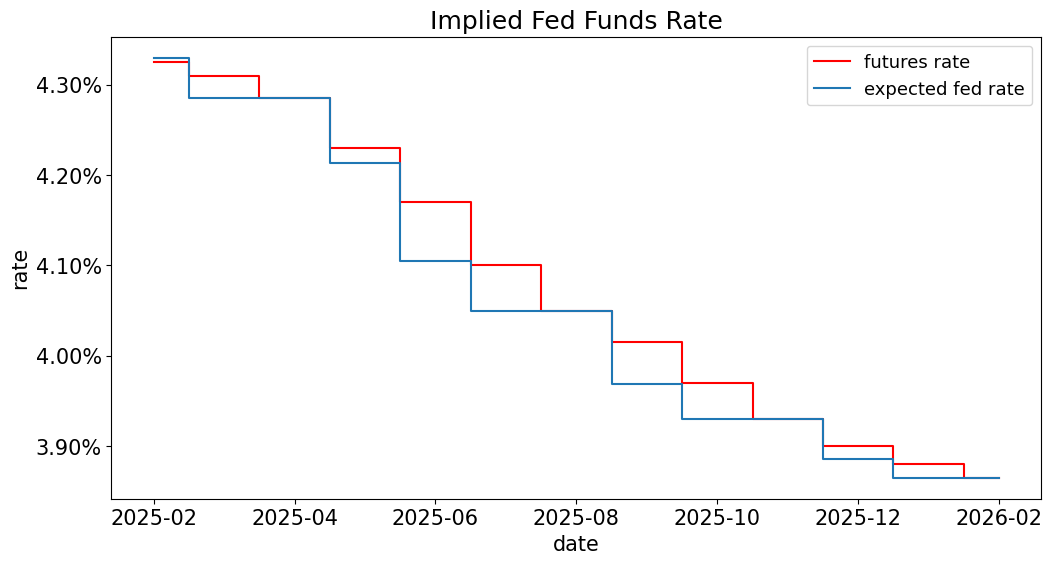

In [17]:
curveplot = curve_info[['futures rate','expected fed rate']].dropna(subset='expected fed rate')
ax = curveplot['futures rate'].plot(drawstyle='steps-mid',color=['red']);
curveplot['expected fed rate'].plot(ax=ax, drawstyle='steps-mid');
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%'));
ax.set_ylabel('rate');
ax.set_title('Implied Fed Funds Rate');
ax.legend(['futures rate','expected fed rate'])
plt.show()

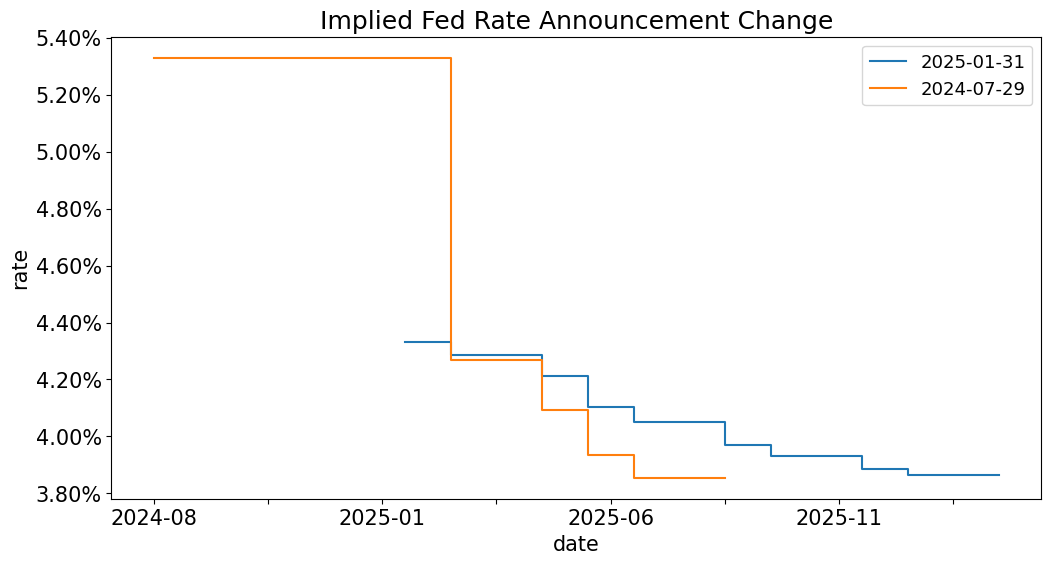

In [18]:
SELECT = [0,2]
dtsSelect = [dates[i] for i in SELECT]

curveplot = merged[dtsSelect]
ax = curveplot.plot(drawstyle='steps-mid')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%'))
ax.set_ylabel('rate')
ax.set_title('Implied Fed Rate Announcement Change')

plt.legend(dtsSelect)
plt.show()

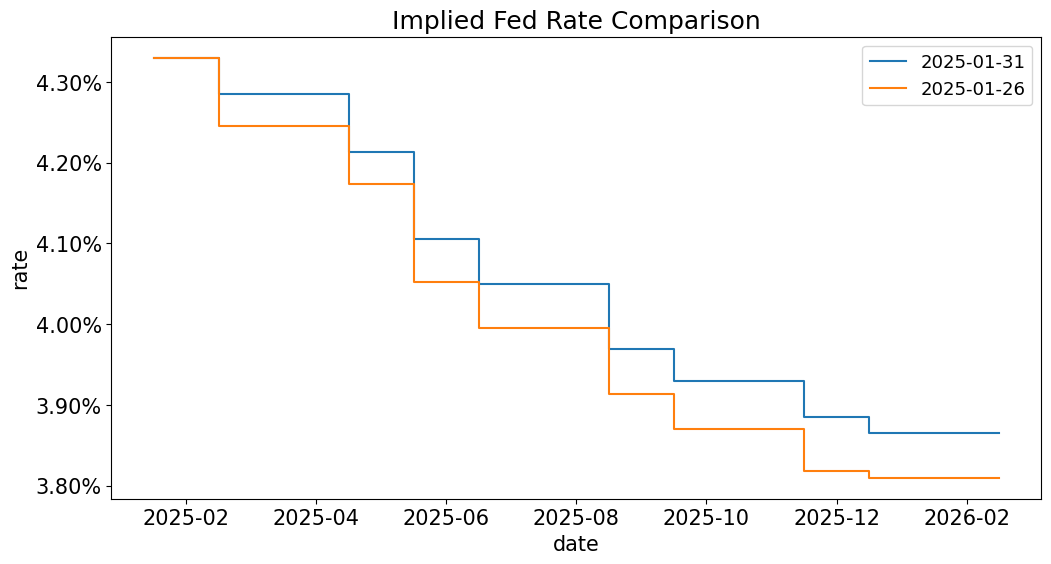

In [19]:
SELECT = [0,1]
dtsSelect = [dates[i] for i in SELECT]

curveplot = merged[dtsSelect]
ax = curveplot.plot(drawstyle='steps-mid')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%'))
ax.set_ylabel('rate');
ax.set_title('Implied Fed Rate Comparison')

plt.legend(dtsSelect)
plt.show()

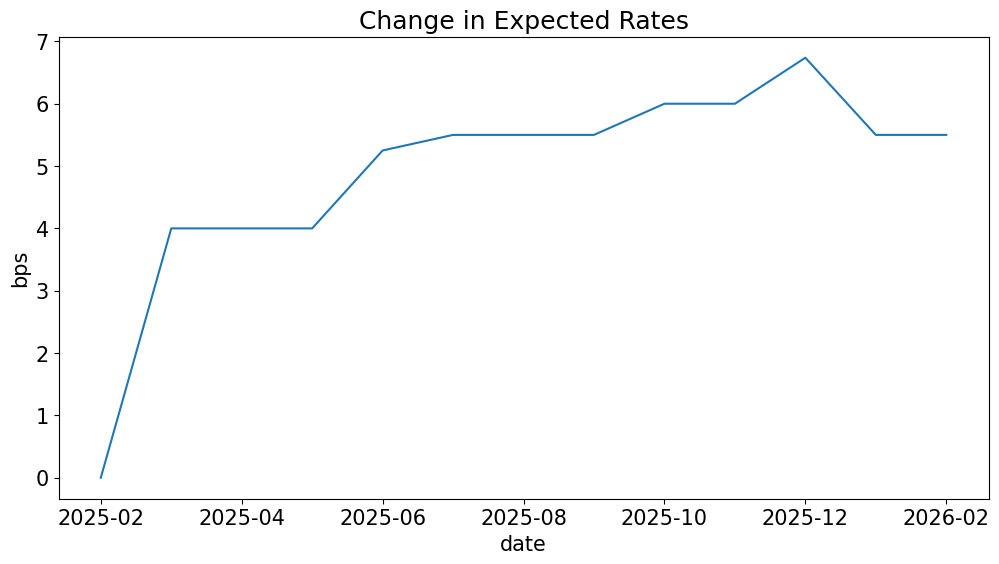

In [20]:
((curveplot['2025-01-31'] - curveplot['2025-01-26'])*100*100).plot(title='Change in Expected Rates',ylabel='bps')
plt.show()

### <span style="color:red">Extra: Looking at Open Interest on the Chain</span>

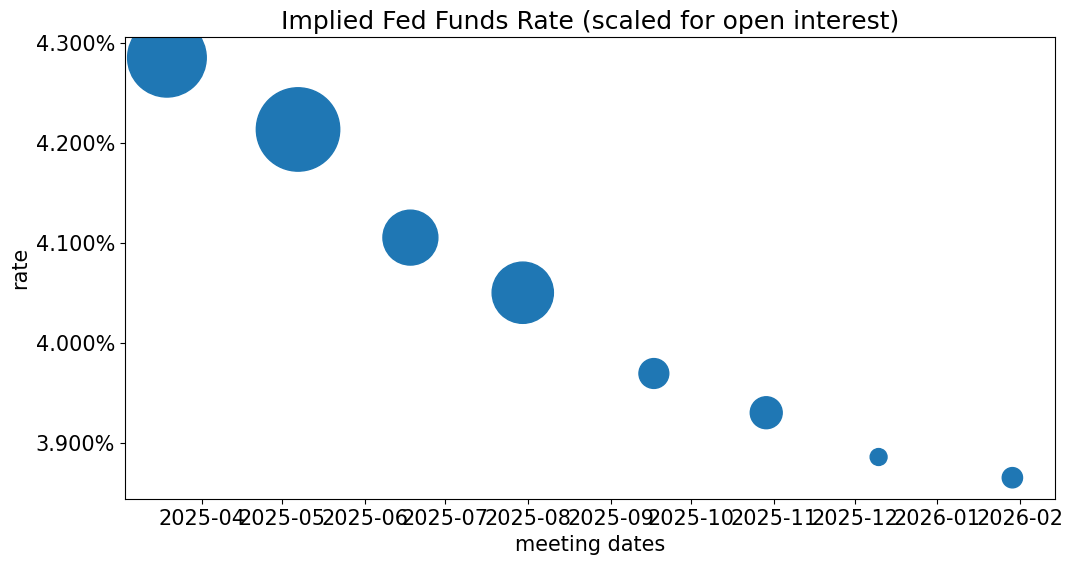

In [21]:
ax = curve_info.plot.scatter(x='meeting dates', y='expected fed rate', s=fedfut[DATE]['open_int']/100);
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%'));
ax.set_ylabel('rate');
ax.set_title('Implied Fed Funds Rate (scaled for open interest)');

***